**Color Correction Matrix (CCM)**

Implementation depends on opencv and numpy.

Calibrating an image using CCM, Algorithm 1:

1. Convert the image from BGR space to linear RGB space.
2. Select the area from the target colorchecker and compute the average pixel values. (targetVal)
3. Create an array containing the reference values of the target colorchecker space. (refVal)
4. Perform color fitting from colorVal to refVal to obtain color correction matrix (CCM):
-- Perform a first order color fit from targetVal to refVal. The resulting color fit matrix is obtained using multiple linear regression
5. Apply the CCM to the target image to see the calibrated image.

source: https://stackoverflow.com/questions/49221892/color-correction-matrix-in-lab-color-space-opencv

Python colormaps ref:
http://pydoc.net/pwkit/0.8.15/pwkit.colormaps/

In [2]:
import os
import numpy as np
import cv2 
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import hsv_to_rgb
import import_ipynb
import colorMapper as cm

importing Jupyter notebook from colorMapper.ipynb
2.0424596801565604
2.3668588191717523
27.14923130074626
[100.   0.   0.]


<Figure size 640x480 with 5 Axes>

[95.27176529 -6.46717026 36.71520784]


In [23]:
#Define the reference RGB values
refRGB = np.array([[115, 82, 69],[204, 161, 141], [101, 134, 179], [89, 109, 61], [141, 137, 194], [132, 228, 208],
          [249, 118, 35], [80, 91, 182], [222, 91, 125], [91, 63, 123], [173, 232, 91], [255, 164, 26],
          [44, 56, 142], [74, 148, 81], [179, 42, 50], [250, 226, 21], [191, 81, 160], [6, 142, 172],
          [252,252,252], [230,230,230], [200,200,200],[143,143,142], [100,100,100],[50,50,50]])

#urineCodes = np.array([[161, 175, 239],[255,243,170],[255,228,100],[255,226,77],[194,142,0],[80,30,30]])
urineCodes = np.array([[161, 175, 239],[255,243,170],[255,226,77],[194,142,0],[80,30,30]])
#urineCodes = np.array([[161, 175, 239],[255,243,170],[194,142,0],[80,30,30]])

print(refRGB.shape)

(24, 3)


In [19]:
'''
This function allows the user to select multiple color ROIs and return the comparison
image to the palette
'''
def CIEDE2000(Lab_1, Lab_2):
    '''Calculates CIEDE2000 color distance between two CIE L*a*b* colors'''
    C_25_7 = 6103515625 # 25**7
    
    L1, a1, b1 = Lab_1[0], Lab_1[1], Lab_1[2]
    L2, a2, b2 = Lab_2[0], Lab_2[1], Lab_2[2]
    C1 = math.sqrt(a1**2 + b1**2)
    C2 = math.sqrt(a2**2 + b2**2)
    C_ave = (C1 + C2) / 2
    G = 0.5 * (1 - math.sqrt(C_ave**7 / (C_ave**7 + C_25_7)))
    
    L1_, L2_ = L1, L2
    a1_, a2_ = (1 + G) * a1, (1 + G) * a2
    b1_, b2_ = b1, b2
    
    C1_ = math.sqrt(a1_**2 + b1_**2)
    C2_ = math.sqrt(a2_**2 + b2_**2)
    
    if b1_ == 0 and a1_ == 0: h1_ = 0
    elif a1_ >= 0: h1_ = math.atan2(b1_, a1_)
    else: h1_ = math.atan2(b1_, a1_) + 2 * math.pi
    
    if b2_ == 0 and a2_ == 0: h2_ = 0
    elif a2_ >= 0: h2_ = math.atan2(b2_, a2_)
    else: h2_ = math.atan2(b2_, a2_) + 2 * math.pi

    dL_ = L2_ - L1_
    dC_ = C2_ - C1_    
    dh_ = h2_ - h1_
    if C1_ * C2_ == 0: dh_ = 0
    elif dh_ > math.pi: dh_ -= 2 * math.pi
    elif dh_ < -math.pi: dh_ += 2 * math.pi        
    dH_ = 2 * math.sqrt(C1_ * C2_) * math.sin(dh_ / 2)
    
    L_ave = (L1_ + L2_) / 2
    C_ave = (C1_ + C2_) / 2
    
    _dh = abs(h1_ - h2_)
    _sh = h1_ + h2_
    C1C2 = C1_ * C2_
    
    if _dh <= math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2
    elif _dh  > math.pi and _sh < 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 + math.pi
    elif _dh  > math.pi and _sh >= 2 * math.pi and C1C2 != 0: h_ave = (h1_ + h2_) / 2 - math.pi 
    else: h_ave = h1_ + h2_
    
    T = 1 - 0.17 * math.cos(h_ave - math.pi / 6) + 0.24 * math.cos(2 * h_ave) + 0.32 * math.cos(3 * h_ave + math.pi / 30) - 0.2 * math.cos(4 * h_ave - 63 * math.pi / 180)
    
    h_ave_deg = h_ave * 180 / math.pi
    if h_ave_deg < 0: h_ave_deg += 360
    elif h_ave_deg > 360: h_ave_deg -= 360
    dTheta = 30 * math.exp(-(((h_ave_deg - 275) / 25)**2))
    
    R_C = 2 * math.sqrt(C_ave**7 / (C_ave**7 + C_25_7))  
    S_C = 1 + 0.045 * C_ave
    S_H = 1 + 0.015 * C_ave * T
    
    Lm50s = (L_ave - 50)**2
    S_L = 1 + 0.015 * Lm50s / math.sqrt(20 + Lm50s)
    R_T = -math.sin(dTheta * math.pi / 90) * R_C

    k_L, k_C, k_H = 1, 1, 1
    
    f_L = dL_ / k_L / S_L
    f_C = dC_ / k_C / S_C
    f_H = dH_ / k_H / S_H
    
    dE_00 = math.sqrt(f_L**2 + f_C**2 + f_H**2 + R_T * f_C * f_H)
    return dE_00

In [26]:
def find_min_distance(targetColorValue):
    urineCodeCIE = cm.srgb_to_cielab(urineCodes)
    targetCIE = cm.srgb_to_cielab(targetColorValue)
    targetCIE = targetCIE.flatten()
    difference = []
    
    for row in urineCodeCIE:       
        difference.append(CIEDE2000(row,targetCIE))

    minIdx = difference.index(min(difference))
    minVal = min(difference)
    
    return minIdx,minVal,difference

def show_urine_colorSwatch():
    code = []
    print(len(urineCodes))
    for i in range(len(urineCodes)):
        code.append(np.full((10,10,3),urineCodes[i],dtype = np.uint8) / 255.0)
        m = i + 1
        plt.subplot(1,len(urineCodes),m)
        plt.imshow(code[i])
    plt.show()

def show_color_swatches(colorMatrix):
    colors = []
    fig,axs = plt.subplots(4,6)
    for i in range(len(colorMatrix)):
        colors.append(np.full((10,10,3),colorMatrix[i],dtype = np.uint8) / 255.0)
        m = i + 1
        plt.subplot(4,6,m)
        plt.imshow(colors[i])
    plt.show()

def show_colorchecker_swatches():
    colors = []
    fig,axs = plt.subplots(4,6)
    for i in range(len(refRGB)):
        colors.append(np.full((10,10,3),refRGB[i],dtype = np.uint8) / 255.0)
        m = i + 1
        plt.subplot(4,6,m)
        plt.imshow(colors[i])
    plt.show()
    
def select_compute_meanRGB(targetImage,ROIs,showOutput=True):
    meanRGB = np.empty((0,3), int)
    for (idx,val) in enumerate(ROIs):
        ROI = targetImage[val[1]:val[1]+val[3], val[0]:val[0]+val[2],:]        
        channelMean = np.mean(ROI.reshape(-1,3),axis=0)
        meanRGB = np.vstack((meanRGB,channelMean))
         
    meanRGB[:,[0,2]] = meanRGB[:,[2,0]]
    return meanRGB

def print_result_status(result):
    if result == 0:
        print("สีปัสสาวะ:ใสเหมือนน้ำ(ดื่มน้ำมากเกินไป),\nคำแนะนำ:ให้ลดปริมาณการดื่มน้ำ จนปัสสาวะเป็นสีเหลือใสจางๆ")
    elif result == 1:
        print("สีปัสสาวะ:สีเหลืองใสจางๆ(ดื่มน้ำเพียงพอ),\nคำแนะนำ:ทหารควรรักษาการดื่มน้ำในปริมาณเดิมให้ได้ตลอดทั้งวัน")
    elif result == 2:
        print("สีปัสสาวะ:สีเหลือง(ดื่มน้ำน้อยเกินไป),\nคำแนะนำ:ทหารต้องดื่มน้ำให้มากขึ้นในทุกๆ ครั้งที่พักการฝึกอย่างน้อยชั่วโมงละ 2 แก้ว(500 ซีซี)")
    elif result == 3:
        print("สีปัสสาวะ:สีเหลืองเข้ม(ดื่มน้ำไม่พอ),\nคำแนะนำ: ทหารต้องดื่มน้ำให้มากขึ้นกว่าปกติ (อย่างน้อยชั่วโมงละ 4 แก้ว (1,000 ซีซี) และ สังเกตสีของปัสสาวะในครั้งถัดไป ถ้ายังเข้มอยู่ให้ดื่มน้ำเพิ่มอีก")
    elif result == 4:
        print("สีปัสสาวะ:สีน้ำตาลำ(มีการสลายของกล้ามเนื้อ อาจทำให้ไตวายได้),\nคำแนะนำ:ทหาใหม่รีบแจ้งครูฝึกทันที และ ครูฝึกต้องรีบนำทหาร ไปพบแพทย์ทันที")
        

In [17]:
#cm.test_color_conversions()

flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
print(flags)

['COLOR_BAYER_BG2BGR', 'COLOR_BAYER_BG2BGRA', 'COLOR_BAYER_BG2BGR_EA', 'COLOR_BAYER_BG2BGR_VNG', 'COLOR_BAYER_BG2GRAY', 'COLOR_BAYER_BG2RGB', 'COLOR_BAYER_BG2RGBA', 'COLOR_BAYER_BG2RGB_EA', 'COLOR_BAYER_BG2RGB_VNG', 'COLOR_BAYER_GB2BGR', 'COLOR_BAYER_GB2BGRA', 'COLOR_BAYER_GB2BGR_EA', 'COLOR_BAYER_GB2BGR_VNG', 'COLOR_BAYER_GB2GRAY', 'COLOR_BAYER_GB2RGB', 'COLOR_BAYER_GB2RGBA', 'COLOR_BAYER_GB2RGB_EA', 'COLOR_BAYER_GB2RGB_VNG', 'COLOR_BAYER_GR2BGR', 'COLOR_BAYER_GR2BGRA', 'COLOR_BAYER_GR2BGR_EA', 'COLOR_BAYER_GR2BGR_VNG', 'COLOR_BAYER_GR2GRAY', 'COLOR_BAYER_GR2RGB', 'COLOR_BAYER_GR2RGBA', 'COLOR_BAYER_GR2RGB_EA', 'COLOR_BAYER_GR2RGB_VNG', 'COLOR_BAYER_RG2BGR', 'COLOR_BAYER_RG2BGRA', 'COLOR_BAYER_RG2BGR_EA', 'COLOR_BAYER_RG2BGR_VNG', 'COLOR_BAYER_RG2GRAY', 'COLOR_BAYER_RG2RGB', 'COLOR_BAYER_RG2RGBA', 'COLOR_BAYER_RG2RGB_EA', 'COLOR_BAYER_RG2RGB_VNG', 'COLOR_BGR2BGR555', 'COLOR_BGR2BGR565', 'COLOR_BGR2BGRA', 'COLOR_BGR2GRAY', 'COLOR_BGR2HLS', 'COLOR_BGR2HLS_FULL', 'COLOR_BGR2HSV', 'COLOR_

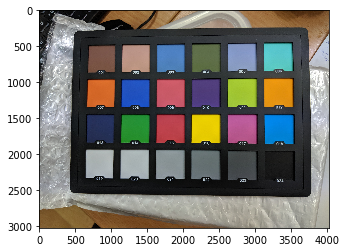

In [18]:
if __name__ == "__main__":
    
    colorChecker = cv2.imread('data/cc-china.jpg')
    cc = cv2.cvtColor(colorChecker,cv2.COLOR_BGR2RGB)
    plt.imshow(cc)

**Select ROIs from the Image**
- Select the color squares to extract the target RGB values
- Compute the mean for the B,G,R channels of each individual target ROI regions
- Swap the B,G,R to R,G,B
- Transform the sRGB values into linear RGB space

In [27]:
    #target = cv2.imread('experiment_data/CC1.jpg')
    target = cv2.imread('test_1/1.jpg')
    target = cv2.resize(target, (600,400),interpolation = cv2.INTER_AREA)
    
    ROIs = cv2.selectROIs('Select ROIs',target, fromCenter=False)
    targetValue = select_compute_meanRGB(target,ROIs)

    cv2.waitKey(0)    
    cv2.destroyAllWindows()

[[155. 172. 232.]]


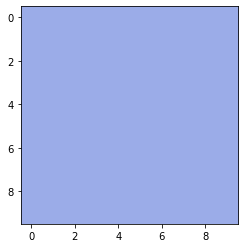

In [28]:
    targetValue = np.round(targetValue)
    print(targetValue)
    
    targetColor = np.full((10,10,3),targetValue,dtype = np.uint8)
    plt.imshow(targetColor)

(240000, 3)


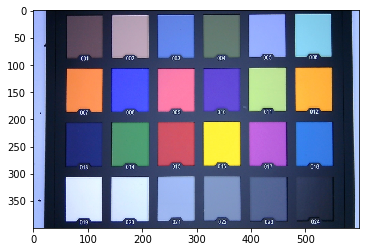

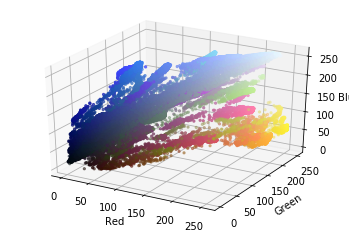

In [9]:
    targetRGB = cv2.cvtColor(target,cv2.COLOR_BGR2RGB)
    plt.imshow(targetRGB)
    r,g,b = cv2.split(targetRGB)
    fig = plt.figure()
    axis = fig.add_subplot(1,1,1,projection="3d")
    
    pixel_colors = targetRGB.reshape((np.shape(targetRGB)[0] * np.shape(targetRGB)[1],3))
    print(pixel_colors.shape)
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()
    
    axis.scatter(r.flatten(),g.flatten(),b.flatten(), facecolors = pixel_colors,marker=".")
    axis.set_xlabel('Red')
    axis.set_ylabel('Green')
    axis.set_zlabel('Blue')
    plt.show()

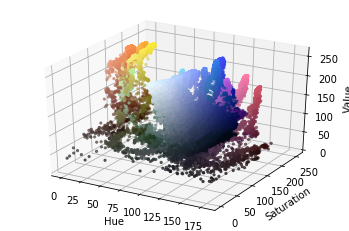

In [10]:
    hsv_urine = cv2.cvtColor(targetRGB, cv2.COLOR_RGB2HSV)
    
    h,s,v = cv2.split(hsv_urine)
    fig = plt.figure()
    axis = fig.add_subplot(1,1,1,projection="3d")
    
    axis.scatter(h.flatten(),s.flatten(), v.flatten(), facecolors = pixel_colors,marker=".")
    axis.set_xlabel('Hue')
    axis.set_ylabel('Saturation')
    axis.set_zlabel('Value')
    plt.show()

**Select the range of HSV Colors and Display**
- Light to Transparent yellows 
- Dark yellow to Dark brown
- Dark brown to red

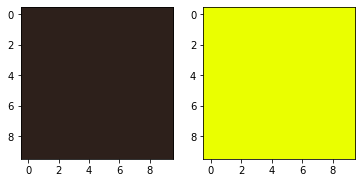

In [11]:
    #light_yellow = (45,40,200)
    light_yellow = (12, 100, 45)
    dark_yellow = (46,255,255)
    
    light_square = np.full((10,10,3),light_yellow,dtype = np.uint8) / 255.0
    dark_square = np.full((10,10,3),dark_yellow,dtype = np.uint8) / 255.0
    
    plt.subplot(1,2,1)
    plt.imshow(hsv_to_rgb(light_square))
    plt.subplot(1,2,2)
    plt.imshow(hsv_to_rgb(dark_square))
    plt.show()

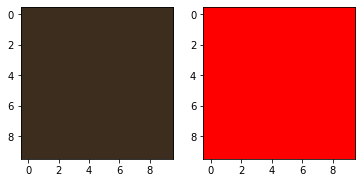

In [12]:
    #light_yellow = (45,40,200)
    light_orange = (20, 120, 60)
    dark_yellow = (255,255,255)
    
    light_orange = np.full((10,10,3),light_orange,dtype = np.uint8) / 255.0
    dark_square = np.full((10,10,3),dark_yellow,dtype = np.uint8) / 255.0
    
    plt.subplot(1,2,1)
    plt.imshow(hsv_to_rgb(light_orange))
    plt.subplot(1,2,2)
    plt.imshow(hsv_to_rgb(dark_square))
    plt.show()

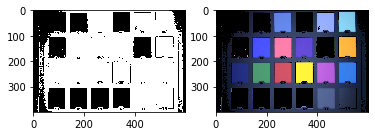

In [29]:
    mask = cv2.inRange(hsv_urine,light_yellow,dark_yellow)
    result = cv2.bitwise_and(targetRGB,targetRGB, mask=mask)
    view = cv2.cvtColor(result,cv2.COLOR_RGB2BGR)
    cv2.imshow("filtered view", view)
    
    plt.subplot(1,2,1)
    plt.imshow(mask,cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(result)
    plt.show()
    
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
    print(targetValue)

5


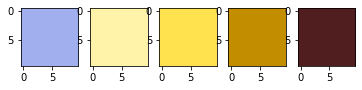


All the difference [1.3583086792237062, 47.334478408312386, 53.93210705056845, 48.996532675989236, 57.15961301169308]

The closest urine code 0

The difference value 1.3583086792237062
Test diff 24.159193541573078


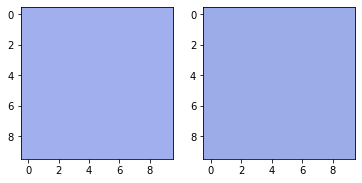

In [30]:
    show_urine_colorSwatch()
    
    minIdx, minVal,difference = find_min_distance(targetValue)
    print("\nAll the difference",difference)
    print("\nThe closest urine code", minIdx)
    print("\nThe difference value", minVal)
    
    urineColorCode = np.full((10,10,3),urineCodes[minIdx],dtype = np.uint8) / 255.0
    targetColor = np.full((10,10,3),targetValue,dtype = np.uint8) / 255.0
    
    test_diff = CIEDE2000(urineCodes[2],urineCodes[3])
    print("Test diff", test_diff)
    
    
    plt.subplot(1,2,1)
    plt.imshow(urineColorCode)
    plt.subplot(1,2,2)
    plt.imshow(targetColor)
    plt.show()

In [31]:
    result_desc = print_result_status(minIdx)

สีปัสสาวะ:ใสเหมือนน้ำ(ดื่มน้ำมากเกินไป),
คำแนะนำ:ให้ลดปริมาณการดื่มน้ำ จนปัสสาวะเป็นสีเหลือใสจางๆ


**Computing the CCM using multiple regression**
- Normalize the reference values to convert from sRGB to linear sRGB space
- Compute the color correction matrix (CCM) using least squares method
- Multiply the CCM with the target values to get RGB values closer to the true colors
- Apply the CCM to the image to see the transformation

In [104]:
    linRefVal = cm.srgb_to_linsrgb(refRGB)
    linTargetVal = cm.srgb_to_linsrgb(targetValue)
    print(linRefVal.shape)
    print(linTargetVal.shape)
    
    #ColorCorrectionMatrix = np.linalg.lstsq(linTargetVal,linRefVal,rcond=None)[0]
    
    ColorCorrectionMatrix = cm.compute_ColorCorrectionMatrix(refRGB,targetValue)
    
    print('------ Color Correction Matrix--------\n')
    print(ColorCorrectionMatrix)
    print('--------------------------------------\n')

(24, 3)
(24, 3)
------ Color Correction Matrix--------

[[ 0.84967679 -0.1428454  -0.0898044 ]
 [ 0.16071465  1.0737733   0.21288119]
 [ 0.03255724  0.02920674  0.54023375]]
--------------------------------------



In [105]:
    corrTargetVal = np.matmul(linTargetVal,ColorCorrectionMatrix)
    
    print("----------Corrected Target Value (Linear)----------------\n")
    print(corrTargetVal)
    print("---------------------------------------------------------\n")
    
    
    corrTargetVal = cm.linsrgb_to_srgb(corrTargetVal)
    print("----------Corrected Target Value (sRGB)----------------\n")
    print(corrTargetVal)
    print("---------------------------------------------------------\n")
    
       
    print("----------Corrected Target Value (sRGB)----------------\n")
    print(targetValue)
    print("---------------------------------------------------------\n")

----------Corrected Target Value (Linear)----------------

[[0.1096756  0.06073802 0.0636606 ]
 [0.48551769 0.33232257 0.28605941]
 [0.17200142 0.266596   0.48918196]
 [0.14212088 0.19230715 0.11870817]
 [0.36353112 0.43949405 0.60254781]
 [0.32903341 0.66923549 0.58395458]
 [0.88291786 0.16625398 0.01879708]
 [0.10464345 0.11230683 0.55249843]
 [0.88948366 0.0982075  0.17617951]
 [0.13991417 0.07799344 0.37862623]
 [0.58793754 0.80049153 0.29653742]
 [0.92744943 0.36711749 0.03869904]
 [0.02489219 0.03325002 0.11903379]
 [0.12299334 0.34608387 0.15555428]
 [0.57214835 0.00610711 0.03364771]
 [0.99789626 0.83893529 0.12898823]
 [0.47646163 0.08283725 0.3795059 ]
 [0.09392016 0.24241059 0.48536008]
 [0.79062262 0.84293201 0.65664701]
 [0.75953381 0.84815858 0.65993286]
 [0.40201037 0.49783817 0.56087225]
 [0.25444053 0.31724846 0.34780002]
 [0.10588488 0.13572226 0.17972584]
 [0.02570103 0.03350167 0.04712399]]
---------------------------------------------------------

----------Correct

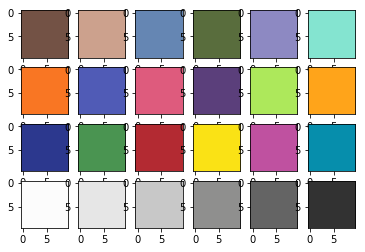

In [121]:
    show_colorchecker_swatches()

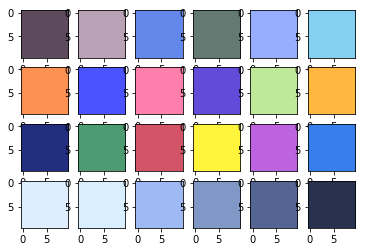

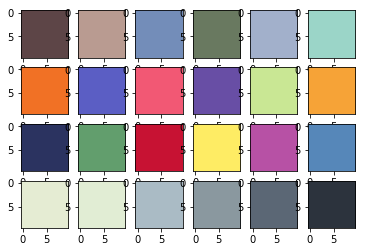

(24, 3)
[93.08708799 69.70888228 71.36469136]


In [140]:
    show_color_swatches(targetValue)
    show_color_swatches(corrTargetVal)
    
    print(corrTargetVal.shape)
    print(corrTargetVal[0])

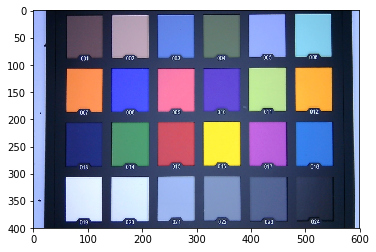

In [180]:
    pltImg = cv2.cvtColor(target,cv2.COLOR_BGR2RGB)
    plt.imshow(pltImg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


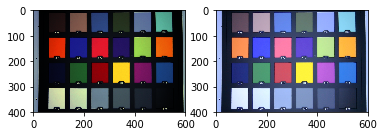

In [178]:
    img = cv2.imread('test_1/CC.jpg')
    img = cv2.resize(target, (600,400),interpolation = cv2.INTER_AREA)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    linImg = cm.srgb_to_linsrgb(img)
    corrImage = np.matmul(linImg,ColorCorrectionMatrix)
    
    #newImage = cm.linsrgb_to_srgb(corrImage)
    #newImage = np.round(newImage)
    newImage[:,[2,0]] = newImage[:,[0,2]]
    #print(newImage)
    #newImage = cv2.cvtColor(corrImage,cv2.COLOR_RGB2BGR)
    #cv2.imshow("Corrected",newImage.astype('float32'))
    #plt.subplot(1,2,1)
    plt.imshow(corrImage)
    plt.subplot(1,2,2)
    plt.imshow(img)
    plt.show()
    
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

**Extract the Urine Color and Map it***
- Understand the range for yellow in RGB / HSV color space. e.g. RGB - (0-255,0-255,0-50) 
- Understand the change in opacity by moving the threshold from (255,255,0)
- Find the urine sample, by first thresholding and filtering for yellow color in the image